In [126]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import sys
!{sys.executable} -m pip install pandas-profiling
!{sys.executable} -m pip install pandasql 
from pandasql import sqldf
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

###############################################################################################
# Process Clinical data
###############################################################################################

patient_data = pd.read_csv('patient_data.csv')
patient = pd.read_csv('patient_data.csv')

patient = patient.set_index('track_name').T
patient = patient[1:]
patient = patient.reset_index()
patient = patient.rename(columns = {'index':'ID'})

patient['ID'] = patient['ID'].str.upper()
patient['Diagnosis Age'] = pd.to_numeric(patient['Diagnosis Age'])
patient['Overall Survival (Months)'] = pd.to_numeric(patient['Overall Survival (Months)'])
patient['Mutation Count'] = pd.to_numeric(patient['Mutation Count'])
patient['Sex'] = patient['Sex'].str.lower()
patient = patient[patient['# Samples per Patient']!='2'].reset_index(drop=True)

def label(x):
    if 'T1' in x:
        return 'T1'
    if 'T2' in x:
        return 'T2'
    if 'T3' in x:
        return 'T3'
    return 'T4'
patient['Stage'] = patient['American Joint Committee on Cancer Tumor Stage Code'].apply(lambda x: label(x))

patient = patient.drop(['Profiled in Mutations','Profiled in Putative copy-number alterations from GISTIC','Patient\'s Vital Status','# Samples per Patient','Cancer Type','Informed consent verified','Neoplasm Histologic Type Name'],axis=1)

###############################################################################################
# Process Tumor mRNA gene expression data
###############################################################################################

mrna_data = pd.read_csv('mrna_data.txt',sep='\t')
mrna = pd.read_csv('mrna_data.txt',sep='\t')

mrna.dropna(thresh=1,axis=1,inplace=True)
mrna = mrna.drop(['STUDY_ID'],axis=1)

def id_process(x):
    new = x[:len(x)-3]
    new = new.replace("_","")
    return new.upper()
mrna['SAMPLE_ID'] = mrna['SAMPLE_ID'].apply(lambda x: id_process(x))

###############################################################################################
# Process Tumor Mutation Sequencing data
###############################################################################################

seq_data = pd.read_csv('seq_data.txt',sep='\t')
seq = pd.read_csv('seq_data.txt',sep='\t')

seq.dropna(how='all',axis=1,inplace=True)
seq = seq.drop(['STUDY_ID'],axis=1)
seq['SAMPLE_ID'] = seq['SAMPLE_ID'].apply(lambda x: id_process(x))
seq = pd.get_dummies(seq, columns=seq.iloc[:,1:].columns,dummy_na=False)

###############################################################################################
# Process combined dataframe
###############################################################################################

def pysqldf(q):
    return sqldf(q, globals())

q = '''
SELECT *
FROM patient
JOIN mrna
ON patient.ID = mrna.SAMPLE_ID
JOIN seq
ON patient.ID = seq.SAMPLE_ID
'''
df = pysqldf(q)

df = df.drop(['SAMPLE_ID'],axis=1)

###############################################################################################
# Impute missing value

from sklearn.neighbors import KNeighborsClassifier

fitting = df
fitting = fitting.iloc[:,:90]
fitting = fitting.drop(['ID','American Joint Committee on Cancer Tumor Stage Code','Overall Survival Status','Sex','Stage'],axis=1)

race_fit = fitting.drop(['Neoplasm Histologic Grade'],axis=1)
null_index = race_fit.isnull().any(axis=1)
row_with_null = race_fit[null_index]
row_no_null = race_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Race Category'],axis=1)
y = row_no_null['Race Category']
clf.fit(x,y)
x_test = row_with_null.drop(['Race Category'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Race Category'] = imputes 

grade_fit = fitting.drop(['Race Category'],axis=1)
null_index = grade_fit.isnull().any(axis=1)
row_with_null = grade_fit[null_index]
row_no_null = grade_fit[-null_index]

clf = KNeighborsClassifier(3, weights='distance')
x = row_no_null.drop(['Neoplasm Histologic Grade'],axis=1)
y = row_no_null['Neoplasm Histologic Grade']
clf.fit(x,y)
x_test = row_with_null.drop(['Neoplasm Histologic Grade'],axis=1)
imputes = clf.predict(x_test)

df.loc[null_index,'Neoplasm Histologic Grade'] = imputes 




In [127]:
df

,ID,American Joint Committee on Cancer Tumor Stage Code,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,...,OR51B4_R124H,OR51B4_V247L,GALNT9_P147Lfs*25,KCNK3_G117D,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,CG-A3-3387,T1a,49,20.27,G2,WHITE,LIVING,male,70,T1,...,0,0,0,0,0,0,0,0,0,0
1,CG-A3-3374,T1b,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,...,0,0,0,0,0,0,0,0,0,0
2,CG-A3-3363,T2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,...,0,0,0,0,0,0,0,0,0,0
3,CG-CZ-5460,T3b,55,94.38,G2,WHITE,LIVING,male,52,T3,...,0,0,0,0,0,0,0,0,0,0
4,CG-BP-4176,T1b,64,64.22,G2,WHITE,LIVING,male,85,T1,...,0,0,0,0,0,0,0,0,0,0
5,CG-CJ-6032,T2,63,119.55,G3,WHITE,LIVING,female,42,T2,...,0,0,0,0,0,0,0,0,0,0
6,CG-BP-5192,T1a,59,23.46,G2,WHITE,LIVING,male,46,T1,...,0,0,0,0,0,0,0,0,0,0
7,CG-CW-5585,T3b,51,85.71,G2,WHITE,LIVING,male,41,T3,...,0,0,0,0,0,0,0,0,0,0
8,CG-B0-5691,T1a,66,112.71,G3,WHITE,LIVING,female,55,T1,...,0,0,0,0,0,0,0,0,0,0
9,CG-AK-3453,T2,58,83.15,G2,WHITE,LIVING,female,350,T2,...,0,0,0,0,0,0,0,0,0,0


In [128]:
df_temp = df
df_temp = df.drop(['ID','American Joint Committee on Cancer Tumor Stage Code'],axis=1)

In [129]:
df_temp

,Diagnosis Age,Overall Survival (Months),Neoplasm Histologic Grade,Race Category,Overall Survival Status,Sex,Mutation Count,Stage,CASR,BEX1,...,OR51B4_R124H,OR51B4_V247L,GALNT9_P147Lfs*25,KCNK3_G117D,PCDHB1_G428R,PCDHB1_P467L,PCDHB1_R79S,LRRTM3_L138F,LRRTM3_N233K,LRRTM3_N504K
0,49,20.27,G2,WHITE,LIVING,male,70,T1,-0.2189,-0.3900,...,0,0,0,0,0,0,0,0,0,0
1,51,43.17,G2,BLACK OR AFRICAN AMERICAN,LIVING,female,934,T1,-0.3084,1.4953,...,0,0,0,0,0,0,0,0,0,0
2,50,10.48,G2,ASIAN,LIVING,male,1392,T2,-0.2440,-0.3324,...,0,0,0,0,0,0,0,0,0,0
3,55,94.38,G2,WHITE,LIVING,male,52,T3,-0.3065,-0.3557,...,0,0,0,0,0,0,0,0,0,0
4,64,64.22,G2,WHITE,LIVING,male,85,T1,-0.3208,-0.3619,...,0,0,0,0,0,0,0,0,0,0
5,63,119.55,G3,WHITE,LIVING,female,42,T2,15.0343,-0.3478,...,0,0,0,0,0,0,0,0,0,0
6,59,23.46,G2,WHITE,LIVING,male,46,T1,2.3700,1.1286,...,0,0,0,0,0,0,0,0,0,0
7,51,85.71,G2,WHITE,LIVING,male,41,T3,5.7473,-0.3720,...,0,0,0,0,0,0,0,0,0,0
8,66,112.71,G3,WHITE,LIVING,female,55,T1,2.7828,-0.1937,...,0,0,0,0,0,0,0,0,0,0
9,58,83.15,G2,WHITE,LIVING,female,350,T2,14.0383,-0.2590,...,0,0,0,0,0,0,0,0,0,0


In [130]:
df_test = df_temp
df_test = pd.get_dummies(df_test, columns=['Sex','Race Category','Neoplasm Histologic Grade','Stage','Overall Survival Status'])


In [131]:
df_test.iloc[:,:83]

,Diagnosis Age,Overall Survival (Months),Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,49,20.27,70,-0.2189,-0.3900,-0.3361,-0.5138,-0.3317,-0.0256,-0.1675,...,-0.0830,-0.1707,-0.2581,0.2143,-0.7927,-0.3291,-0.2567,-0.1539,-0.1217,0.0041
1,51,43.17,934,-0.3084,1.4953,-0.3371,-0.6901,-0.2625,-0.5939,-0.1345,...,-0.0274,-0.2045,-0.2581,-0.7088,-0.7921,1.3842,-0.9107,-0.3519,-0.4425,-0.4822
2,50,10.48,1392,-0.2440,-0.3324,0.4572,9.8551,-0.4222,-0.0040,16.2764,...,-0.0830,-0.0711,-0.2581,2.3981,-0.1062,-0.4213,-0.9130,0.6727,0.8858,-0.4822
3,55,94.38,52,-0.3065,-0.3557,-0.3371,-0.6237,-0.3941,-0.0430,-0.3020,...,-0.0834,-0.2214,-0.2581,0.3389,-0.7828,-0.3776,-0.3862,-0.3519,-0.0984,-0.4822
4,64,64.22,85,-0.3208,-0.3619,-0.3335,-0.6163,-0.4168,1.6013,-0.2730,...,-0.0831,-0.2204,-0.2581,1.6625,-0.5232,-0.2374,-0.6744,-0.3519,0.7024,-0.4822
5,63,119.55,42,15.0343,-0.3478,2.8270,2.3959,-0.2378,0.4683,0.4648,...,-0.0834,-0.0367,-0.2581,2.0796,2.8367,-0.0034,2.6966,-0.3519,-0.4425,-0.4822
6,59,23.46,46,2.3700,1.1286,2.6795,-0.6950,-0.3297,-0.5588,-0.2651,...,-0.0833,-0.1788,2.1204,-0.7067,1.8769,0.0741,0.5387,-0.3519,-0.1193,-0.4822
7,51,85.71,41,5.7473,-0.3720,-0.2978,3.7813,-0.0900,0.3211,1.2776,...,-0.0834,-0.2157,0.4244,-0.2330,-0.1921,-0.1149,-0.6306,5.4844,-0.1644,0.9936
8,66,112.71,55,2.7828,-0.1937,0.1911,1.1727,-0.3629,0.5175,0.4211,...,-0.0805,0.4493,1.7371,-0.0836,0.0447,-0.2206,-0.7109,-0.0173,-0.4425,1.1613
9,58,83.15,350,14.0383,-0.2590,-0.3371,-0.6945,0.3441,-0.3078,0.1378,...,-0.0766,0.0422,0.1464,-0.7109,-0.7739,-0.3746,-0.9265,1.8864,-0.1127,33.0062


In [132]:
def null_to_zero(x):
    if x == 0:
        return None
    return x

df_test['Mutation Count'] = df_test['Mutation Count'].apply(lambda x: null_to_zero(x))


In [133]:
df_test.isnull().sum()

Diagnosis Age                               0
Overall Survival (Months)                   0
Mutation Count                             83
CASR                                        0
BEX1                                        0
MYH8                                        0
SPON1                                       0
FABP4                                       0
SLITRK5                                     0
CBLN2                                       0
DGKK                                        0
RGS7                                        0
SHISA6                                      0
LYPD4                                       0
SPAG11A                                     0
SORCS3                                      0
SERPINB2                                    0
BNC1                                        0
DIPK1C                                      0
PCP4                                        0
RORB                                        0
HPCAL4                            

In [134]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df_test.iloc[:,:83] = scaler.fit_transform(df_test.iloc[:,:83])

In [171]:
df_test.iloc[:,:83]

,Diagnosis Age,Overall Survival (Months),Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,...,NMRK2,GAL3ST3,MYMK,PLPPR5,GALNT9,UBE2QL1,KCNK3,PCDHB1,CXADRP3,LRRTM3
0,-0.958603,-0.741759,-0.030631,-0.194704,-0.360206,-0.312010,-0.507745,-0.311841,0.016756,-0.147743,...,-0.083584,-0.173809,-0.261508,0.203979,-0.769431,-0.347406,-0.330934,-0.204844,-0.140573,-0.046908
1,-0.793855,-0.031539,6.724819,-0.267978,1.218277,-0.312896,-0.687085,-0.234251,-0.574249,-0.112553,...,-0.024356,-0.208402,-0.261508,-0.700499,-0.768807,1.445127,-0.897537,-0.405603,-0.483525,-0.244104
2,-0.876229,-1.045386,10.305833,-0.215254,-0.311980,0.390556,10.039903,-0.413313,0.039219,17.387345,...,-0.083584,-0.071873,-0.261508,2.343723,-0.056431,-0.443870,-0.899530,0.633276,0.936498,-0.244104
3,-0.464360,1.556686,-0.171369,-0.266423,-0.331488,-0.312896,-0.619540,-0.381806,-0.001339,-0.291168,...,-0.084010,-0.225698,-0.261508,0.326065,-0.759148,-0.398149,-0.443129,-0.405603,-0.115664,-0.244104
4,0.277005,0.621305,0.086651,-0.278130,-0.336679,-0.309707,-0.612012,-0.407258,1.708656,-0.260243,...,-0.083691,-0.224675,-0.261508,1.622963,-0.489528,-0.251465,-0.692815,-0.405603,0.740434,-0.244104
5,0.194632,2.337308,-0.249558,12.293202,-0.324874,2.489308,2.452115,-0.206556,0.530389,0.526516,...,-0.084010,-0.036666,-0.261508,2.031648,3.000066,-0.006644,2.227703,-0.405603,-0.483525,-0.244104
6,-0.134864,-0.642825,-0.218282,1.924847,0.911254,2.358678,-0.692069,-0.309598,-0.537747,-0.251819,...,-0.083904,-0.182099,2.334321,-0.698441,2.003217,0.074440,0.358173,-0.405603,-0.138007,-0.244104
7,-0.793855,1.287795,-0.257376,4.689868,-0.345135,-0.278090,3.861397,-0.040836,0.377308,1.393252,...,-0.084010,-0.219865,0.483353,-0.234298,-0.145647,-0.123300,-0.654868,5.512032,-0.186221,0.354337
8,0.441753,2.125172,-0.147913,2.262810,-0.195852,0.154891,1.207828,-0.346823,0.581555,0.479916,...,-0.080921,0.460733,1.915998,-0.087912,0.100293,-0.233888,-0.724438,-0.066340,-0.483525,0.422339
9,-0.217238,1.208399,2.158635,11.477770,-0.250525,-0.312896,-0.691561,0.445895,-0.276719,0.177817,...,-0.076767,0.044084,0.179952,-0.702557,-0.749905,-0.395010,-0.911226,1.863890,-0.130951,13.335527


In [136]:
import sys
!{sys.executable} -m pip install impyute 

import impyute

In [234]:
df_knn = df_test.copy(deep=True)
df_em = df_test.copy(deep=True)
df_rem = df_test.copy(deep=True)

In [235]:
df_knn['Mutation Count'] = impyute.imputation.cs.fast_knn(df_test,k=5).iloc[:,2]

In [237]:
df_knn

,Diagnosis Age,Overall Survival (Months),Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,...,Neoplasm Histologic Grade_G2,Neoplasm Histologic Grade_G3,Neoplasm Histologic Grade_G4,Neoplasm Histologic Grade_GX,Stage_T1,Stage_T2,Stage_T3,Stage_T4,Overall Survival Status_DECEASED,Overall Survival Status_LIVING
0,-0.958603,-0.741759,-0.030631,-0.194704,-0.360206,-0.312010,-0.507745,-0.311841,0.016756,-0.147743,...,1,0,0,0,1,0,0,0,0,1
1,-0.793855,-0.031539,6.724819,-0.267978,1.218277,-0.312896,-0.687085,-0.234251,-0.574249,-0.112553,...,1,0,0,0,1,0,0,0,0,1
2,-0.876229,-1.045386,10.305833,-0.215254,-0.311980,0.390556,10.039903,-0.413313,0.039219,17.387345,...,1,0,0,0,0,1,0,0,0,1
3,-0.464360,1.556686,-0.171369,-0.266423,-0.331488,-0.312896,-0.619540,-0.381806,-0.001339,-0.291168,...,1,0,0,0,0,0,1,0,0,1
4,0.277005,0.621305,0.086651,-0.278130,-0.336679,-0.309707,-0.612012,-0.407258,1.708656,-0.260243,...,1,0,0,0,1,0,0,0,0,1
5,0.194632,2.337308,-0.249558,12.293202,-0.324874,2.489308,2.452115,-0.206556,0.530389,0.526516,...,0,1,0,0,0,1,0,0,0,1
6,-0.134864,-0.642825,-0.218282,1.924847,0.911254,2.358678,-0.692069,-0.309598,-0.537747,-0.251819,...,1,0,0,0,1,0,0,0,0,1
7,-0.793855,1.287795,-0.257376,4.689868,-0.345135,-0.278090,3.861397,-0.040836,0.377308,1.393252,...,1,0,0,0,0,0,1,0,0,1
8,0.441753,2.125172,-0.147913,2.262810,-0.195852,0.154891,1.207828,-0.346823,0.581555,0.479916,...,0,1,0,0,1,0,0,0,0,1
9,-0.217238,1.208399,2.158635,11.477770,-0.250525,-0.312896,-0.691561,0.445895,-0.276719,0.177817,...,1,0,0,0,0,1,0,0,0,1


In [238]:
df_em['Mutation Count'] = impyute.imputation.cs.em(df_test).iloc[:,2]

In [239]:
df_em

,Diagnosis Age,Overall Survival (Months),Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,...,Neoplasm Histologic Grade_G2,Neoplasm Histologic Grade_G3,Neoplasm Histologic Grade_G4,Neoplasm Histologic Grade_GX,Stage_T1,Stage_T2,Stage_T3,Stage_T4,Overall Survival Status_DECEASED,Overall Survival Status_LIVING
0,-0.958603,-0.741759,-0.030631,-0.194704,-0.360206,-0.312010,-0.507745,-0.311841,0.016756,-0.147743,...,1,0,0,0,1,0,0,0,0,1
1,-0.793855,-0.031539,6.724819,-0.267978,1.218277,-0.312896,-0.687085,-0.234251,-0.574249,-0.112553,...,1,0,0,0,1,0,0,0,0,1
2,-0.876229,-1.045386,10.305833,-0.215254,-0.311980,0.390556,10.039903,-0.413313,0.039219,17.387345,...,1,0,0,0,0,1,0,0,0,1
3,-0.464360,1.556686,-0.171369,-0.266423,-0.331488,-0.312896,-0.619540,-0.381806,-0.001339,-0.291168,...,1,0,0,0,0,0,1,0,0,1
4,0.277005,0.621305,0.086651,-0.278130,-0.336679,-0.309707,-0.612012,-0.407258,1.708656,-0.260243,...,1,0,0,0,1,0,0,0,0,1
5,0.194632,2.337308,-0.249558,12.293202,-0.324874,2.489308,2.452115,-0.206556,0.530389,0.526516,...,0,1,0,0,0,1,0,0,0,1
6,-0.134864,-0.642825,-0.218282,1.924847,0.911254,2.358678,-0.692069,-0.309598,-0.537747,-0.251819,...,1,0,0,0,1,0,0,0,0,1
7,-0.793855,1.287795,-0.257376,4.689868,-0.345135,-0.278090,3.861397,-0.040836,0.377308,1.393252,...,1,0,0,0,0,0,1,0,0,1
8,0.441753,2.125172,-0.147913,2.262810,-0.195852,0.154891,1.207828,-0.346823,0.581555,0.479916,...,0,1,0,0,1,0,0,0,0,1
9,-0.217238,1.208399,2.158635,11.477770,-0.250525,-0.312896,-0.691561,0.445895,-0.276719,0.177817,...,1,0,0,0,0,1,0,0,0,1


In [240]:
df_rem = df_rem[-df_test['Mutation Count'].isnull()]

In [241]:
df_rem[-df_test['Mutation Count'].isnull()]

,Diagnosis Age,Overall Survival (Months),Mutation Count,CASR,BEX1,MYH8,SPON1,FABP4,SLITRK5,CBLN2,...,Neoplasm Histologic Grade_G2,Neoplasm Histologic Grade_G3,Neoplasm Histologic Grade_G4,Neoplasm Histologic Grade_GX,Stage_T1,Stage_T2,Stage_T3,Stage_T4,Overall Survival Status_DECEASED,Overall Survival Status_LIVING
0,-0.958603,-0.741759,-0.030631,-0.194704,-0.360206,-0.312010,-0.507745,-0.311841,0.016756,-0.147743,...,1,0,0,0,1,0,0,0,0,1
1,-0.793855,-0.031539,6.724819,-0.267978,1.218277,-0.312896,-0.687085,-0.234251,-0.574249,-0.112553,...,1,0,0,0,1,0,0,0,0,1
2,-0.876229,-1.045386,10.305833,-0.215254,-0.311980,0.390556,10.039903,-0.413313,0.039219,17.387345,...,1,0,0,0,0,1,0,0,0,1
3,-0.464360,1.556686,-0.171369,-0.266423,-0.331488,-0.312896,-0.619540,-0.381806,-0.001339,-0.291168,...,1,0,0,0,0,0,1,0,0,1
4,0.277005,0.621305,0.086651,-0.278130,-0.336679,-0.309707,-0.612012,-0.407258,1.708656,-0.260243,...,1,0,0,0,1,0,0,0,0,1
5,0.194632,2.337308,-0.249558,12.293202,-0.324874,2.489308,2.452115,-0.206556,0.530389,0.526516,...,0,1,0,0,0,1,0,0,0,1
6,-0.134864,-0.642825,-0.218282,1.924847,0.911254,2.358678,-0.692069,-0.309598,-0.537747,-0.251819,...,1,0,0,0,1,0,0,0,0,1
7,-0.793855,1.287795,-0.257376,4.689868,-0.345135,-0.278090,3.861397,-0.040836,0.377308,1.393252,...,1,0,0,0,0,0,1,0,0,1
8,0.441753,2.125172,-0.147913,2.262810,-0.195852,0.154891,1.207828,-0.346823,0.581555,0.479916,...,0,1,0,0,1,0,0,0,0,1
9,-0.217238,1.208399,2.158635,11.477770,-0.250525,-0.312896,-0.691561,0.445895,-0.276719,0.177817,...,1,0,0,0,0,1,0,0,0,1


In [242]:
df_knn = df_knn.drop(['Overall Survival Status_LIVING','Overall Survival (Months)'],axis=1)

In [243]:
df_em = df_em.drop(['Overall Survival Status_LIVING','Overall Survival (Months)'],axis=1)

In [244]:
df_rem = df_rem.drop(['Overall Survival Status_LIVING','Overall Survival (Months)'],axis=1)

In [245]:
df_knn_clean = df_knn.drop(df_knn.columns[82:187],axis=1)

In [246]:
df_em_clean = df_em.drop(df_em.columns[82:187],axis=1)

In [247]:
df_rem_clean = df_rem.drop(df_rem.columns[82:187],axis=1)

In [248]:
def split(df,test_sample_size):
    y = df[['Overall Survival Status_DECEASED']]
    x = df.drop(['Overall Survival Status_DECEASED'],axis=1)
    
    from sklearn import model_selection

    # Reserve 20% for testing
    x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=test_sample_size)
    
    print('training data has %d observation with %d features'% x_train.shape)
    print('test data has %d observation with %d features'% x_test.shape)
    
    return x_train, x_test, y_train, y_test

In [346]:
x_train, x_test, y_train, y_test = split(df_rem,0.2)

training data has 359 observation with 201 features
test data has 90 observation with 201 features


In [406]:
x_train, x_test, y_train, y_test = split(df_knn,0.2)

training data has 425 observation with 201 features
test data has 107 observation with 201 features


In [366]:
x_train, x_test, y_train, y_test = split(df_em,0.2)

training data has 425 observation with 201 features
test data has 107 observation with 201 features


In [407]:
#@title build models
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.linear_model import LogisticRegression

# Logistic Regression
classifier_logistic = LogisticRegression()

# K Nearest Neighbors
classifier_KNN = KNeighborsClassifier(n_neighbors=3)

# Random Forest
classifier_RF = RandomForestClassifier()

# GB Regression
classifier_GB = GradientBoostingClassifier()

In [409]:
# Train the model by logistic regression
classifier_logistic.fit(x_train, y_train)
classifier_logistic.predict(x_test)
# Accuracy of test data
classifier_logistic.score(x_test, y_test)

0.7757009345794392

In [410]:
# Train the model by kNN
classifier_KNN.fit(x_train, y_train)
classifier_KNN.predict(x_test)
# Accuracy of test data
classifier_KNN.score(x_test, y_test)

0.7289719626168224

In [411]:
# Train the model by random forest
classifier_RF.fit(x_train, y_train)
classifier_RF.predict(x_test)
# Accuracy of test data
classifier_RF.score(x_test, y_test)

0.7476635514018691

In [412]:
# Train the model by gradient boosting
classifier_GB.fit(x_train, y_train)
classifier_GB.predict(x_test)
# Accuracy of test data
classifier_GB.score(x_test, y_test)

0.7570093457943925

In [413]:
from sklearn.model_selection import GridSearchCV

# helper function for printing out grid search results 
def print_grid_search_metrics(gs):
    print ("Best score: %0.3f" % gs.best_score_)
    print ("Best parameters set:")
    best_parameters = gs.best_params_
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

In [414]:
# Possible hyperparamter options for Logistic Regression Regularization
# Penalty is choosed from L1 or L2
# C is the lambda value(weight) for L1 and L2
parameters = {
    'penalty':('l1', 'l2'), 
    'C':(0.01,0.05,0.1,0.15,0.2,0.25,0.3,0.4,0.5)
}
Grid_LR = GridSearchCV(LogisticRegression(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_LR.fit(x_train, y_train)

# the best hyperparameter combination
print_grid_search_metrics(Grid_LR)

# best LR model
best_LR_model = Grid_LR.best_estimator_

Best score: 0.715
Best parameters set:
	C: 0.05
	penalty: 'l2'


In [456]:
best_LR_model.predict(x_test)
# Accuracy of test data
best_LR_model.score(x_test, y_test)

0.822429906542056

In [416]:
# Possible hyperparamter options for Random Forest
# Choose the number of trees
parameters = {
    'n_estimators' : [50,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,90,100],
    'min_samples_split': [3, 5, 10, 15, 20], 
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20, 30 ,50]
}
Grid_RF = GridSearchCV(RandomForestClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_RF.fit(x_train, y_train)

# best number of tress
print_grid_search_metrics(Grid_RF)

# best random forest
best_RF_model = Grid_RF.best_estimator_

Best score: 0.755
Best parameters set:
	max_depth: 15
	max_features: 20
	min_samples_split: 5
	n_estimators: 79


In [418]:
best_RF_model.predict(x_test)
# Accuracy of test data
best_RF_model.score(x_test, y_test)

0.794392523364486

In [420]:
# Possible hyperparamter options for KNN
# Choose k
parameters = {
    'n_neighbors':[1,2,3,4,5,6,7,8,9,10,15,20,25,30,50] 
}
Grid_KNN = GridSearchCV(KNeighborsClassifier(),parameters, cv=10, scoring='recall_weighted',n_jobs=-1)
Grid_KNN.fit(x_train, y_train)

# best k
print_grid_search_metrics(Grid_KNN)

# best KNN model
best_KNN_model = Grid_KNN.best_estimator_

Best score: 0.696
Best parameters set:
	n_neighbors: 9


In [421]:
best_KNN_model.predict(x_test)
# Accuracy of test data
best_KNN_model.score(x_test, y_test)

0.7570093457943925

In [450]:
# Possible hyperparamter options for Gradient Boosting Decision Tree
# Choose the number of trees
parameters = {
    'n_estimators' : (30,35,40,45,50,55,60,65,70,75,80),
    'learning_rate' : (0.05,0.1,0.15,0.2,0.3),
    'subsample' : (0.5,0.6,0.7,0.8,0.9,1),
    'max_depth': [3, 5, 10, 15, 20, 25],
    'max_features': [3, 5, 10, 20, 30, 50]
}
Grid_GB = GridSearchCV(GradientBoostingClassifier(),parameters, cv=10,scoring='recall_weighted',n_jobs=-1)
Grid_GB.fit(x_train, y_train)

# best number of tress
print_grid_search_metrics(Grid_GB)

# best Gradient Boosting Decision Tree
best_GB_model = Grid_GB.best_estimator_


Best score: 0.762
Best parameters set:
	learning_rate: 0.1
	max_depth: 15
	max_features: 20
	n_estimators: 80
	subsample: 1


In [451]:
best_GB_model.predict(x_test)
# Accuracy of test data
best_GB_model.score(x_test, y_test)

0.8037383177570093

Logistic Regression
Accuracy is: 0.822
precision is: 0.652
recall is: 0.577


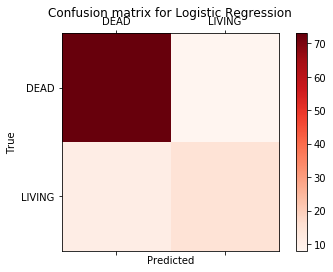

Random Forest
Accuracy is: 0.794
precision is: 0.611
recall is: 0.423


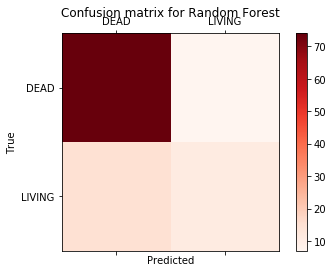

Gradient Boosting
Accuracy is: 0.804
precision is: 0.632
recall is: 0.462


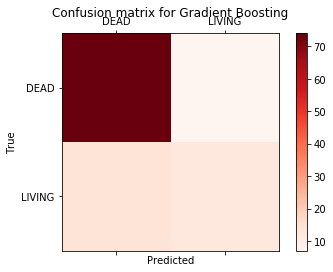

In [454]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# calculate accuracy, precision and recall
def cal_evaluation(classifier, cm):
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

# print out confusion matrices
def draw_confusion_matrices(confusion_matricies):
    class_names = ['DEAD','LIVING']
    for cm in confusion_matrices:
        classifier, cm = cm[0], cm[1]
        cal_evaluation(classifier, cm)
        fig = plt.figure()
        ax = fig.add_subplot(111)
        cax = ax.matshow(cm, interpolation='nearest',cmap=plt.get_cmap('Reds'))
        plt.title('Confusion matrix for %s' % classifier)
        fig.colorbar(cax)
        ax.set_xticklabels([''] + class_names)
        ax.set_yticklabels([''] + class_names)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()
        
%matplotlib inline

# Confusion matrix, accuracy, precison and recall for random forest and logistic regression
confusion_matrices = [
    ("Logistic Regression", confusion_matrix(y_test,best_LR_model.predict(x_test))),
    ("Random Forest", confusion_matrix(y_test,best_RF_model.predict(x_test))),
    ("Gradient Boosting", confusion_matrix(y_test,best_GB_model.predict(x_test)))
    
]

draw_confusion_matrices(confusion_matrices)

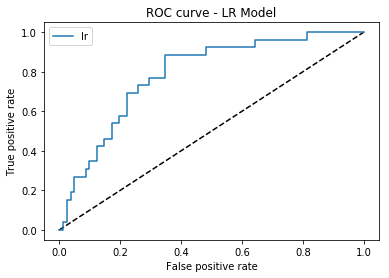

In [422]:
from sklearn.metrics import roc_curve
from sklearn import metrics

# Use predict_proba to get the probability results of Logistic Regression
y_pred_lr = best_LR_model.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='lr')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - LR Model')
plt.legend(loc='best')
plt.show()

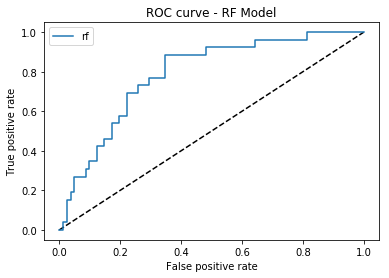

In [424]:
# Use predict_proba to get the probability results of Random Forest
y_pred_rf = best_RF_model.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
# ROC Curve
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='rf')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - RF Model')
plt.legend(loc='best')
plt.show()

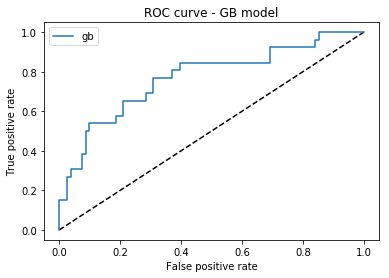

In [455]:
# Use predict_proba to get the probability results of Gradient Boosting model
y_pred_gb = best_GB_model.predict_proba(x_test)[:, 1]
fpr_gb, tpr_gb, _ = roc_curve(y_test, y_pred_gb)

# ROC curve of Gradient Boosting result
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_gb, tpr_gb, label='gb')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - GB model')
plt.legend(loc='best')
plt.show()

(0, 1)

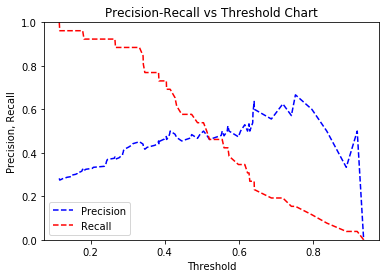

In [426]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_lr) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

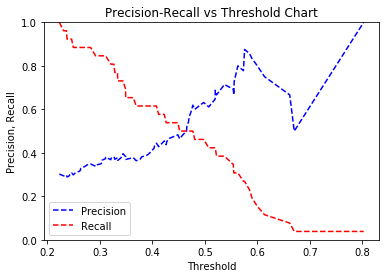

In [427]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_rf) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

(0, 1)

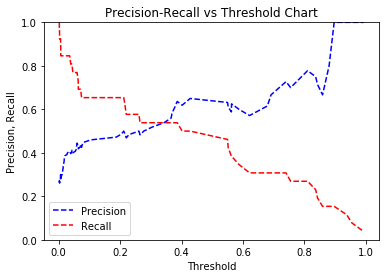

In [457]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_gb) 
   #retrieve probability of being 1(in second column of probs_y)
pr_auc = metrics.auc(recall, precision)

plt.title("Precision-Recall vs Threshold Chart")
plt.plot(thresholds, precision[: -1], "b--", label="Precision")
plt.plot(thresholds, recall[: -1], "r--", label="Recall")
plt.ylabel("Precision, Recall")
plt.xlabel("Threshold")
plt.legend(loc="lower left")
plt.ylim([0,1])

In [460]:
def threshold_performance(classifier, threshold):
    cm = confusion_matrix(y_test,(classifier.predict_proba(x_test)[:,1] >= threshold).astype(int))
    tn = cm[0][0]
    fp = cm[0][1]
    fn = cm[1][0]
    tp = cm[1][1]
    accuracy  = (tp + tn) / (tp + fp + fn + tn + 0.0)
    precision = tp / (tp + fp + 0.0)
    recall = tp / (tp + fn + 0.0)
    print (classifier)
    print ("Threshold is: %0.3f" % threshold)
    print ("Accuracy is: %0.3f" % accuracy)
    print ("precision is: %0.3f" % precision)
    print ("recall is: %0.3f" % recall)

In [478]:
(y_train.sum()/len(y_train))[0]

0.35058823529411764

In [479]:
threshold_performance(best_LR_model, (y_train.sum()/len(y_train))[0])

LogisticRegression(C=0.05, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
Threshold is: 0.351
Accuracy is: 0.785
precision is: 0.537
recall is: 0.846


In [487]:
best_LR_model.predict(x_test)

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [491]:
(best_LR_model.predict_proba(x_test)[:,1] >= 0.3).astype(int)

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

In [493]:
y_test['Overall Survival Status_DECEASED'].as_matrix()

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
      dtype=uint8)

In [434]:
x = df_knn.drop(['Overall Survival Status_DECEASED'],axis=1)
y = df_knn['Overall Survival Status_DECEASED']

LRmodel_l1 = best_LR_model
LRmodel_l1.fit(x, y)
LRmodel_l1.coef_[0]
print ("Logistic Regression (L1) Coefficients")
for k,v in sorted(zip(map(lambda x: round(x, 4), LRmodel_l1.coef_[0]), \
                      x.columns), key=lambda k_v:(-abs(k_v[0]),k_v[1])):
    print (v + ": " + str(k))

Logistic Regression (L1) Coefficients
Stage_T1: -0.4631
Neoplasm Histologic Grade_G2: -0.4381
Diagnosis Age: 0.4318
Neoplasm Histologic Grade_G4: 0.3915
SHISA6: -0.3118
HIST1H2AM: 0.2776
DGKK: -0.2757
PCDHB1: -0.2712
SLITRK6: 0.2439
NTRK2: -0.2378
CXADRP3: 0.2302
DPEP1: -0.2087
RLN1: -0.2078
PCP4: -0.2073
RIIAD1: -0.2054
BEX1: 0.1895
STARD6: 0.1845
Race Category_BLACK OR AFRICAN AMERICAN: -0.1799
Sex_female: -0.1741
CASR: -0.1712
TRIM63: -0.1695
XIST: 0.1595
MYMK: 0.1592
S100A1: 0.1534
Mutation Count: -0.1501
Neoplasm Histologic Grade_G1: -0.1498
DEFA4: -0.1482
BNC1: 0.1417
F12: -0.1402
USH1G: -0.1378
MS4A3: 0.1375
LCN10: 0.1321
LYPD4: -0.1284
Sex_male: -0.1277
Stage_T4: 0.1271
SLC17A8: 0.1265
AVP: 0.1235
DIPK1C: 0.122
NXF2: 0.1214
KCND2: 0.1198
CHRNA4: 0.1171
SPON1: -0.1162
UBE2QL1: -0.1158
Stage_T3: 0.1151
MYH8: -0.1127
EPHA7: 0.1118
GAL3ST3: 0.1025
KCTD8: 0.1025
EPS8L3: -0.1003
NPB: 0.0983
TMEM179: -0.0956
CAPSL: 0.093
FABP4: 0.092
SLC6A17: 0.0916
SORCS1: -0.0827
PNMT: -0.0825
FGF7:

In [496]:
# check feature importance of random forest for feature selection
x_feature_importance = df_knn.drop(['Overall Survival Status_DECEASED'],axis=1)
y = df_knn['Overall Survival Status_DECEASED']

forest = RandomForestClassifier()
forest.fit(x_feature_importance, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), x_feature_importance.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
ROS1: 0.0302
Neoplasm Histologic Grade_G4: 0.0286
Diagnosis Age: 0.0282
HIST1H2AM: 0.0256
SERPINB2: 0.0245
Stage_T1: 0.0229
BNC1: 0.021
EPS8L3: 0.0199
SPON1: 0.0193
NPB: 0.0193
USH1G: 0.0191
UBE2QL1: 0.0187
BEX1: 0.0177
DGKK: 0.0173
SCG2: 0.017
NTRK2: 0.0164
LCN10: 0.0162
TCEAL2: 0.0161
AVP: 0.016
Stage_T3: 0.0157
PLA2G1B: 0.0155
SORCS3: 0.0152
FABP4: 0.0152
DPEP1: 0.0152
Mutation Count: 0.0148
CBLN2: 0.0146
PCDHB1: 0.0142
SLITRK5: 0.0139
RLN1: 0.0136
SLC6A17: 0.0131
POF1B: 0.0131
CXADRP3: 0.0129
GALNT9: 0.0127
CASR: 0.0124
SORCS1: 0.0122
FOXP2: 0.0119
SHISA6: 0.0113
KCNK3: 0.0112
CHRNA4: 0.0111
HPCAL4: 0.0109
FGF7: 0.0109
KCNJ1: 0.0108
SCRT1: 0.0104
KCND2: 0.0104
TUBA4B: 0.0102
PNMT: 0.0099
PCP4: 0.0099
DIPK1C: 0.0097
F12: 0.0096
SLC17A8: 0.0095
Neoplasm Histologic Grade_G2: 0.0095
PRSS12: 0.0094
PLPPR5: 0.0094
LYPD4: 0.0093
FBXL21P: 0.009
MYH8: 0.0089
EPHA7: 0.0089
RIIAD1: 0.0088
ABCG8: 0.0087
XIST: 0.0083
KCTD8: 0.0083
DEFB1: 0.008


In [448]:
# check feature importance of random forest for feature selection
x_feature_importance = df_knn.drop(['Overall Survival Status_DECEASED'],axis=1)
y = df_knn['Overall Survival Status_DECEASED']

forest = RandomForestClassifier(max_depth=15,max_features=20,min_samples_split=5,n_estimators=79)
forest.fit(x_feature_importance, y)

importances = forest.feature_importances_

# Print the feature ranking
print("Feature importance ranking by Random Forest Model:")
for k,v in sorted(zip(map(lambda x: round(x, 4), importances), x_feature_importance.columns), reverse=True):
    print (v + ": " + str(k))

Feature importance ranking by Random Forest Model:
Neoplasm Histologic Grade_G4: 0.033
Stage_T1: 0.0256
HIST1H2AM: 0.0253
Diagnosis Age: 0.025
LYPD4: 0.0211
UBE2QL1: 0.0196
NPB: 0.0178
DPEP1: 0.0178
KCND2: 0.0172
XIST: 0.0164
PPP1R14D: 0.0164
SORCS3: 0.0161
SLC6A17: 0.016
BEX1: 0.0158
Stage_T3: 0.0154
SHISA6: 0.0151
PLA2G1B: 0.0151
SCG2: 0.0141
SERPINB2: 0.0139
HPCAL4: 0.0138
NTRK2: 0.0136
F12: 0.0134
ABCG8: 0.0133
KCNK3: 0.0132
GALNT9: 0.0132
TUBA4B: 0.0131
RORB: 0.0131
PRSS12: 0.0131
FABP4: 0.0128
POF1B: 0.0126
BNC1: 0.0121
DIPK1C: 0.012
CXADRP3: 0.012
SLITRK5: 0.0119
ROS1: 0.0119
KCNJ1: 0.0119
FOXP2: 0.0117
USH1G: 0.0115
TRIM63: 0.0115
SCRT1: 0.0114
EPHA7: 0.0114
DEFB1: 0.0113
CD5L: 0.0113
EPS8L3: 0.0111
CATSPERZ: 0.0111
Neoplasm Histologic Grade_G2: 0.0108
LCN10: 0.0106
FGF7: 0.0106
CASR: 0.0106
TCEAL2: 0.0105
SPON1: 0.0105
SORCS1: 0.0105
FBXL21P: 0.0104
GAL3ST3: 0.0099
Mutation Count: 0.0095
S100A1: 0.0087
AVP: 0.0087
KCTD8: 0.0085
CBLN2: 0.0085
PLPPR5: 0.0081
TMEM179: 0.008
SLC17

In [495]:
df.columns

Index(['ID', 'American Joint Committee on Cancer Tumor Stage Code',
       'Diagnosis Age', 'Overall Survival (Months)',
       'Neoplasm Histologic Grade', 'Race Category', 'Overall Survival Status',
       'Sex', 'Mutation Count', 'Stage',
       ...
       'OR51B4_R124H', 'OR51B4_V247L', 'GALNT9_P147Lfs*25', 'KCNK3_G117D',
       'PCDHB1_G428R', 'PCDHB1_P467L', 'PCDHB1_R79S', 'LRRTM3_L138F',
       'LRRTM3_N233K', 'LRRTM3_N504K'],
      dtype='object', length=195)